## Download the Dataset

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od


In [3]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [4]:
#od.download(dataset_url)

## Import the Dataset Into PyTorch

Use the ImageFolder class from torchvision.

In [5]:
data_dir = './flowers-recognition/flowers'

In [6]:
import os

In [7]:
os.listdir(data_dir)

['daisy', 'dandelion', 'rose', 'tulip', 'sunflower']

In [8]:
for cls in os.listdir(data_dir):
  print(cls, len(os.listdir(data_dir + '/' + cls)))

daisy 764
dandelion 1052
rose 784
tulip 984
sunflower 733


In [9]:
from torchvision.datasets import ImageFolder

In [10]:
dataset = ImageFolder(data_dir)

In [11]:
len(dataset)

4317

In [12]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FBC548B93D0>, 0)

In [13]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [14]:
import matplotlib.pyplot as plt

In [15]:
%matplotlib inline

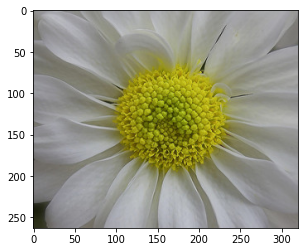

In [16]:
img, label = dataset[0]
plt.imshow(img)

In [17]:
import torchvision.transforms as tt



1.   Convert all the images to the same size(Note if height > width then the width will be equal to the size given and height will be greater than the width and vice versa)
2.   To convert all the images to the same dimensions we need to do the RandomCrop after the Resize



In [18]:
# CONVERT PIL Image to Image Tensors

dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(64), 
                                           tt.RandomCrop(64),
                                          tt.ToTensor()]))

In [19]:
# img, label = dataset[0]
# plt.imshow(img) #TypeError: Invalid shape (3, 224, 224) for image data

# Torch Vision creates images with channels as the first dimension, however 
# we need images with channel as the last dimension

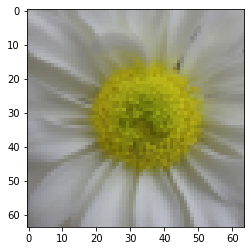

In [20]:
# We need to put the first dimension into the last dimension

img, label = dataset[0]
plt.imshow(img.permute((1,2,0)))

In [21]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size,val_size

(3886, 431)

In [22]:
from torch.utils.data import random_split

In [23]:
train_ds , valid_ds = random_split(dataset,[train_size,val_size])

In [24]:
len(train_ds), len(valid_ds)

(3886, 431)

In [25]:
from torch.utils.data import DataLoader

In [26]:
batch_size = 128 #256

train_dl = DataLoader(train_ds,batch_size,shuffle = True, num_workers=4,pin_memory=True)
val_dl = DataLoader(valid_ds,batch_size,num_workers=4,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
from torchvision.utils import make_grid
# Show images in batch
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


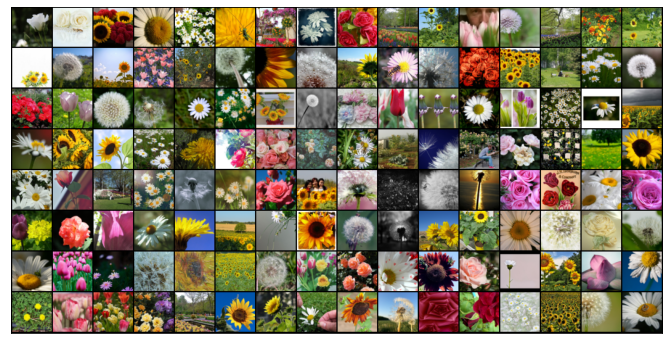

In [28]:
show_batch(train_dl)

## Utility Functions and Classes

### GPU Utilities

In [29]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
torch.cuda.is_available()

True

In [31]:
device = get_default_device()

In [32]:
device # cuda is the language that is used to communicate to the gpu

device(type='cuda')

In [33]:
img , label = dataset[0]

In [34]:
img.shape

torch.Size([3, 64, 64])

In [35]:

img_gpu = to_device(img,device)
img_gpu.device

device(type='cuda', index=0)

In [36]:
# We will use the Deice Data Loader class that we built 

train_dl =  DeviceDataLoader(train_dl, device)
val_dl =  DeviceDataLoader(val_dl, device)

### Model and Training Utilities

In [37]:
# Single Label Class problem we use cross entropy (1 image belongs to 1 class eg Flower Recognition)
# For multi label Class problem we use Binary Cross Entropy (1 image belongs to multiple  class eg Protein images can have multiple classes)
# For Regression problem we use Mean Sqquared Error Loss

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model


    Convolution Layer (64 filters), Batch Norm, ReLU
    Convolution Layer (128 filters), Batch Norm, ReLU
    Max Pooling Layer (factor of 2)
    Convolution Layer (128 filters), Batch Norm, ReLU
    Convolution Layer (128 filters), Batch Norm, ReLU
    Residual Connection (3+5)
    Convolution Layer (256 filters), Batch Norm, ReLU
    Max Pooling Layer (factor of 2)
    Convolution Layer (512 filters), Batch Norm, ReLU
    Pooling Layer (factor of 2)
    Convolution Layer (512 filters), Batch Norm, ReLU
    Convolution Layer (512 filters), Batch Norm, ReLU
    Residual Connection (10+12)
    Max Pooling Layer (factor of 4)
    Flatten
    Fully Connected Layer (10 classes)
    Multiplication Layer (multiply all logits by 0.125)


In [40]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        # AdaptiveMaxPool2d(1) works with images of any length, all pretrained models use AdaptiveMaxPool2d in last layer
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [41]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [42]:
model.conv1[0].weight

Parameter containing:
tensor([[[[-0.1808,  0.0367,  0.1543],
          [-0.0405,  0.0696,  0.0960],
          [-0.0803, -0.0141,  0.0316]],

         [[ 0.0141,  0.0290,  0.0301],
          [ 0.1257,  0.0479,  0.0091],
          [-0.1197,  0.0818, -0.1111]],

         [[-0.1172,  0.1336, -0.0598],
          [ 0.0417, -0.0551,  0.0701],
          [-0.1029,  0.0060,  0.1880]]],


        [[[-0.0978,  0.0024, -0.0068],
          [ 0.1863, -0.1028,  0.1190],
          [-0.0637, -0.1048, -0.0453]],

         [[-0.1919, -0.0276, -0.1577],
          [ 0.1617, -0.0084, -0.0230],
          [ 0.1095,  0.0948, -0.0664]],

         [[ 0.0046,  0.0775,  0.1668],
          [-0.1734,  0.1291,  0.1160],
          [-0.1292, -0.1628, -0.1293]]],


        [[[-0.1066,  0.1466,  0.0169],
          [-0.0433,  0.1660,  0.1483],
          [-0.0740, -0.0321, -0.1329]],

         [[-0.1525, -0.0884,  0.1280],
          [-0.1023,  0.0127, -0.0538],
          [-0.0032,  0.1708, -0.0432]],

         [[ 0.0915,  0

In [43]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass One batch of input tensor through the model to test if everything is working

In [45]:
for batch in train_dl:
  images,labels=batch
  print('images.shape',images.shape)
  print('images.device',images.device)
  preds = model(images)
  print('preds.shape',preds.shape)
  break

# Note this will give us error, CUDA out of memory, so we need to change the batch_size from 256 to 128 and reduce image size to 64

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


# Training

In [48]:
# This is our baseline accuracy(without training)
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.17623835802078247, 'val_loss': 1.6166311502456665}]

In [50]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.5207, val_loss: 1.2147, val_acc: 0.4996
Epoch [1], train_loss: 0.9892, val_loss: 0.9447, val_acc: 0.6512
Epoch [2], train_loss: 0.8856, val_loss: 0.7327, val_acc: 0.7300
Epoch [3], train_loss: 0.7568, val_loss: 0.8855, val_acc: 0.7009
Epoch [4], train_loss: 0.6824, val_loss: 0.7013, val_acc: 0.7375


In [52]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.5558, val_loss: 0.5728, val_acc: 0.7760
Epoch [1], train_loss: 0.5231, val_loss: 0.5851, val_acc: 0.7657
Epoch [2], train_loss: 0.4830, val_loss: 0.5500, val_acc: 0.7799
Epoch [3], train_loss: 0.4613, val_loss: 0.5593, val_acc: 0.7973
Epoch [4], train_loss: 0.4327, val_loss: 0.5770, val_acc: 0.7847


In [58]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.4311, val_loss: 0.5289, val_acc: 0.7998
Epoch [1], train_loss: 0.3869, val_loss: 0.5451, val_acc: 0.7920
Epoch [2], train_loss: 0.3703, val_loss: 0.5337, val_acc: 0.7920
Epoch [3], train_loss: 0.3528, val_loss: 0.5053, val_acc: 0.8252
Epoch [4], train_loss: 0.3093, val_loss: 0.5174, val_acc: 0.8236


In [59]:
history += fit(5, 0.0001, model, train_dl, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2900, val_loss: 0.4788, val_acc: 0.8339
Epoch [1], train_loss: 0.2915, val_loss: 0.5126, val_acc: 0.8168
Epoch [2], train_loss: 0.2774, val_loss: 0.4849, val_acc: 0.8280
Epoch [3], train_loss: 0.2770, val_loss: 0.4964, val_acc: 0.8241
Epoch [4], train_loss: 0.2777, val_loss: 0.5077, val_acc: 0.8202


In [60]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

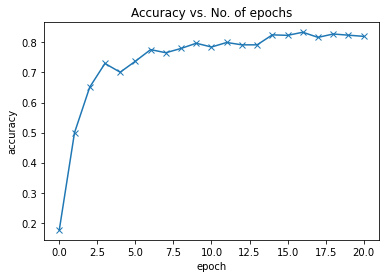

In [61]:
plot_accuracies(history)

In [62]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

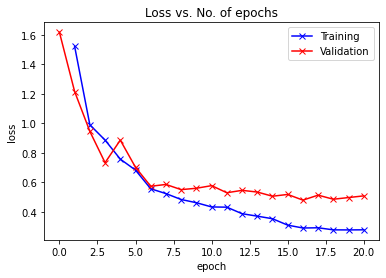

In [63]:
plot_losses(history)

In [70]:
history[-1]

{'train_loss': 0.2776833176612854,
 'val_acc': 0.8201878070831299,
 'val_loss': 0.507682204246521}

### Record the results

# Test with Individual Images

In [71]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [72]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: dandelion
Prediction: dandelion


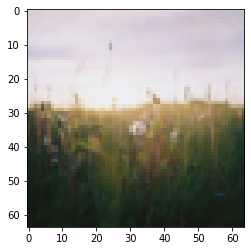

In [74]:
show_image_prediction(*valid_ds[100])

Target: dandelion
Prediction: dandelion


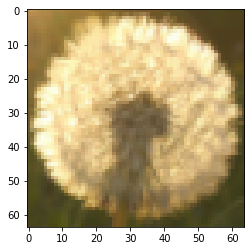

In [75]:
show_image_prediction(*valid_ds[300])

Target: rose
Prediction: rose


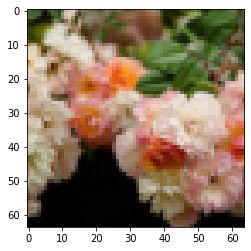

In [76]:
show_image_prediction(*valid_ds[12])

In [78]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')